In [4]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchinfo
import torch.optim as optim
import time
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from medmnist import OCTMNIST
import warnings
warnings.filterwarnings("ignore")

In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # Resize to 28x28 if necessary
    transforms.Resize(size=(28, 28), antialias=True),
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 32

# Define the dataset
dataset = OCTMNIST(root='../medmnist', split='train', download=True, transform=transform)

# Calculate sizes for each split
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

Using downloaded and verified file: ../medmnist/octmnist.npz


In [7]:
# Dataloaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

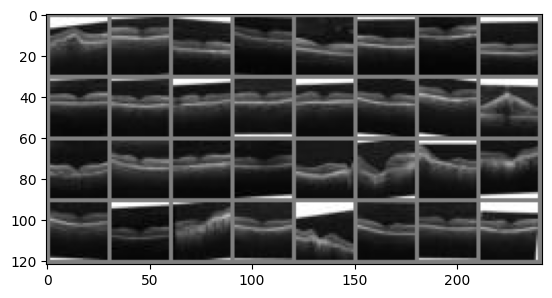

choroidal neovascularization normal normal normal normal normal normal normal normal diabetic macular edema normal normal normal normal normal diabetic macular edema choroidal neovascularization drusen normal normal diabetic macular edema choroidal neovascularization choroidal neovascularization choroidal neovascularization normal normal choroidal neovascularization normal choroidal neovascularization normal normal diabetic macular edema


In [8]:
classes = list(dataset.info['label'].values())

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 4)
        self.dropout = nn.Dropout(p=0.2)  # Dropout layer with p=0.2

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        # Applying dropout after the first fully connected layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        # Applying dropout after the second fully connected layer
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [10]:
modelCNN = CNN()
print(modelCNN)

CNN(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=4, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [11]:
# Define regularization (L2)
l2_reg = 0.001 # Regularization parameter
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(modelCNN.parameters(), lr=0.001, weight_decay=l2_reg)


In [12]:
import time

startTime = time.time()

training_loss_plt_arr = []
validation_loss_plt_arr = []
testing_loss_plt_arr = []

epochs = 5
consecutive_increases = 3
increase_count = 0
best_validation_loss = float('inf')

for epoch in range(epochs):
    training_loss = 0.0

    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = modelCNN(inputs)
        labels = labels.flatten()
        loss_training = criterion(outputs, labels)
        loss_training.backward()
        optimizer.step()

        training_loss += loss_training.item()

        if i % 500 == 499:
            validation_loss = 0.0
            with torch.no_grad():
                for data in valloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    labels = labels.flatten()
                    loss_validation = criterion(outputs, labels)
                    validation_loss += loss_validation.item()

            testing_loss = 0.0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data
                    outputs = modelCNN(images)
                    labels = labels.flatten()
                    loss_testing = criterion(outputs, labels)
                    testing_loss += loss_testing.item()

            training_loss = round((training_loss / 500), 3)
            validation_loss = round((validation_loss / len(valloader)), 3)
            testing_loss = round((testing_loss / len(testloader)), 3)

            print(f"[{epoch + 1}, {i + 1}], Training loss: {training_loss}, Validation loss: {validation_loss}, Testing loss: {testing_loss}")

            training_loss_plt_arr.append(training_loss)
            validation_loss_plt_arr.append(validation_loss)
            testing_loss_plt_arr.append(testing_loss)
            training_loss = 0.0

            # Early stopping condition
            if validation_loss <= best_validation_loss:
                best_validation_loss = validation_loss
                increase_count = 0
            else:
                increase_count += 1
                if increase_count == consecutive_increases:
                    print("Stopping training as Validation Loss stopped improving.")
                    break

    if increase_count == consecutive_increases:
        break

print("Finished Training")

endTime = time.time()
time_to_train = (endTime - startTime)

# Convert total time to minutes and seconds
minutes = int(time_to_train // 60)
seconds = int(time_to_train % 60)

print(f"\nTime to train: {minutes}min {seconds}sec")

[1, 500], Training loss: 0.867, Validation loss: 0.69, Testing loss: 0.679
[1, 1000], Training loss: 0.639, Validation loss: 0.585, Testing loss: 0.581
[1, 1500], Training loss: 0.569, Validation loss: 0.535, Testing loss: 0.534
[1, 2000], Training loss: 0.547, Validation loss: 0.512, Testing loss: 0.511
[2, 500], Training loss: 0.512, Validation loss: 0.515, Testing loss: 0.508
[2, 1000], Training loss: 0.505, Validation loss: 0.482, Testing loss: 0.48
[2, 1500], Training loss: 0.481, Validation loss: 0.508, Testing loss: 0.503
[2, 2000], Training loss: 0.472, Validation loss: 0.547, Testing loss: 0.549
[3, 500], Training loss: 0.463, Validation loss: 0.461, Testing loss: 0.46
[3, 1000], Training loss: 0.449, Validation loss: 0.447, Testing loss: 0.449
[3, 1500], Training loss: 0.451, Validation loss: 0.452, Testing loss: 0.454
[3, 2000], Training loss: 0.446, Validation loss: 0.438, Testing loss: 0.434
[4, 500], Training loss: 0.431, Validation loss: 0.448, Testing loss: 0.455
[4, 10

In [13]:
# Save model with weights
torch.save(modelCNN.state_dict(), 'ngupta22_ assignment0_bonus.h5')

In [14]:
def loadersAccuracy(loader):
    modelCNN.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = modelCNN(images)
            _, predicted = torch.max(outputs.data, 1)
            labels = labels.flatten()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total * 100)
    return round(accuracy,2)

In [15]:
loadersAccuracy(testloader)

85.43